# Classification

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

### Displaying images

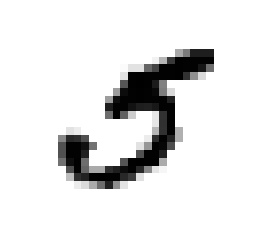

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, 
           cmap = matplotlib.cm.binary, 
           interpolation = "nearest")
plt.axis("off")
plt.show()

In [5]:
X_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a binary classifier

In [7]:
y_train_5 = (y_train == 5) # true for all 5s
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

### implementing cross-validation

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9501
0.94275
0.96515


The stratified k folds performs a stratified sampling to produce folds that contain a representatice ratio of each class.


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9501 ,  0.94275,  0.96515])

### What about a simple classifier always scoring not-5

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([ 0.9098 ,  0.90995,  0.9092 ])

### Let's evaluate confusion matrix

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[52694,  1885],
       [  955,  4466]])

The first row considers the negative class (non-5 images)

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.70319634703196343

In [15]:
recall_score(y_train_5, y_train_pred)

0.82383324109942813

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.75874957526333675

In [17]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 12761.32763394])

In [18]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [19]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

### Let's select the right threshold using the precision and recall curve

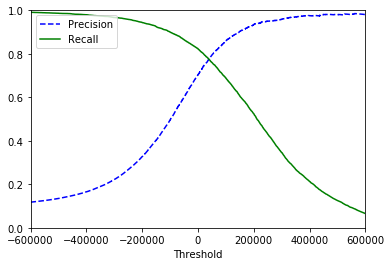

In [20]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.xlim([-600000, 600000])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

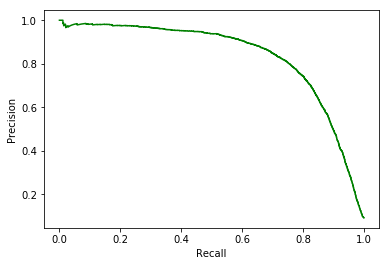

In [21]:
plt.plot(recalls[:-1], precisions[:-1], "g-")
plt.xlabel("Recall")
plt.ylabel("Precision")

Aiming for 90% of precision we get ~60% recall, this mean a threshold of ~70,000. Let's change the prediction

In [22]:
y_train_pred_90 = (y_scores > 150000)
precision_score(y_train_5, y_train_pred_90)

0.90304861301840156

In [23]:
recall_score(y_train_5, y_train_pred_90)

0.60653016048699504

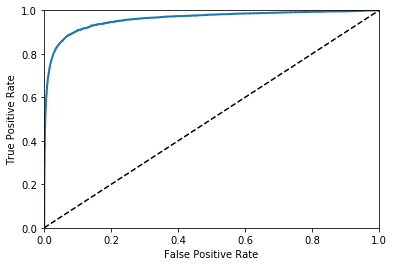

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.95981671296748206

### Tips of using Precision/Recall curve vs ROC

Use PR whenever the positive class is rare or when you care more about the false positive than the false negatives and the ROC otherwise.

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # probabilities of positive class

In [27]:
y_scores_forest

array([ 0.1,  0. ,  0.1, ...,  0. ,  0. ,  0. ])

In [28]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [29]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
tpr_forest

array([ 0.28242022,  0.49640288,  0.6452684 ,  0.74451208,  0.82641579,
        0.88396975,  0.92289246,  0.95683453,  0.97804833,  0.99335916,  1.        ])

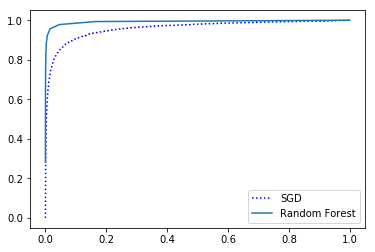

In [30]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.99305081175114196

In [32]:
y_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_pred)

0.98267163851721873

In [33]:
recall_score(y_train_5, y_pred)

0.82641579044456748

### Multiclass classification

Some algorithms such as random forests or naive bayes handle this natively but others such as SVM and linear classifiers need a few tricks like training a different binary classifier for each class.

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

Behind the scenes scikit-learn trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [35]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -52389.71897099, -429797.61117103, -308989.51314538,
        -166218.21315659, -381327.60232572,   12761.32763394,
        -793205.00002711, -337208.94454506, -512557.90331092,
        -715712.69006186]])

In [36]:
np.argmax(some_digit_scores)

5

In [37]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [38]:
sgd_clf.classes_[5]

5.0

### Forcing OneVsAll or OneVsOne

In [39]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [40]:
len(ovo_clf.estimators_)

45

In [41]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [42]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0. ,  0.1,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86352729,  0.8739937 ,  0.79626944])

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Couldn't figure out why I get a memory error

array([ 0.9110178 ,  0.90879544,  0.90913637])

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5734,    2,   27,   10,    9,   45,   46,   10,   38,    2],
       [   1, 6480,   49,   21,    6,   36,    7,   11,  118,   13],
       [  53,   37, 5352,   87,   80,   23,   94,   49,  166,   17],
       [  49,   45,  140, 5319,    3,  231,   36,   54,  139,  115],
       [  22,   25,   35,    6, 5352,   10,   54,   32,   77,  229],
       [  78,   42,   41,  183,   65, 4614,  103,   30,  165,  100],
       [  35,   29,   44,    2,   39,   95, 5626,    5,   43,    0],
       [  23,   22,   74,   26,   56,    9,    7, 5796,   13,  239],
       [  55,  150,   79,  154,   17,  160,   52,   28, 4996,  160],
       [  43,   33,   27,   82,  153,   37,    2,  190,   72, 5310]])

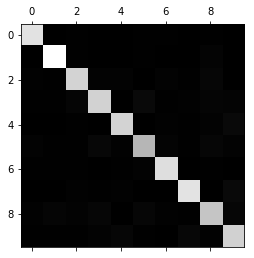

In [46]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

<function matplotlib.pyplot.show>

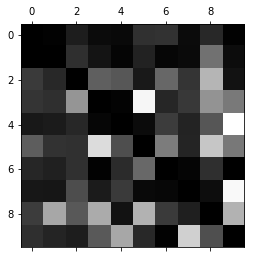

In [47]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show

<function matplotlib.pyplot.show>

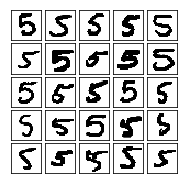

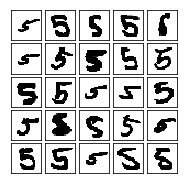

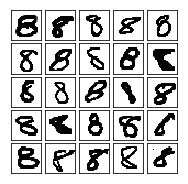

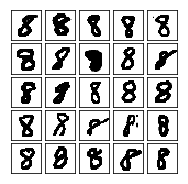

In [48]:
cl_a, cl_b = 5, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(data):
    flg, axes = plt.subplots(5, 5, 
                             figsize=(3,3), 
                             subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28,28),
                 cmap='binary', interpolation='nearest',
                 clim=(0, 16))

plot_digits(X_aa[:25])
plot_digits(X_ab[:25])
plot_digits(X_ba[:25])
plot_digits(X_bb[:25])
plt.show
